In [315]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from dataclasses import dataclass
from types import SimpleNamespace
from dateutil.relativedelta import relativedelta
from typing import NamedTuple

plt.rcParams["figure.figsize"] = (8,5)

DATA_DIR = Path("/Users/antoineboilot/Desktop/M2/Fixed Income/Python/group/FIN2764/data")
BOND_CSV = DATA_DIR / "bond_data.csv"            # replace with your real file
DB_MODEL_CSV = DATA_DIR / "db_model_zc.csv"      # optional, for Q1.2
SETTLEMENT_DATE = pd.Timestamp("2025-10-31")     # adjust if needed
DAY_COUNT = "ACT/ACT"
COMPOUNDING = "cont"  # "cont", "annual", or "semi"

np.random.seed(42)

bonds = pd.read_csv(
    BOND_CSV,
    sep=";",              # si le fichier est en point-virgule
    decimal=",",          # virgule décimale -> float
    encoding="utf-8-sig",
    dayfirst=True,
    parse_dates=["maturity_date"]
)

db = pd.read_csv(
    DB_MODEL_CSV,
    sep=";",              # si le fichier est en point-virgule
    decimal=",",          # virgule décimale -> float
    encoding="utf-8-sig",
    dayfirst=True,
)
db["y_model"] = db["y_model"].str.rstrip("%").astype(float) / 100

bonds
 


/var/folders/q7/l7l15_r10wb757zsr385rbcm0000gn/T/ipykernel_67185/3830230340.py:21: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  bonds = pd.read_csv(


,maturity_date,coupon_rate,current_price
0,2004-02-15,3.000,101.0544
1,2004-08-15,2.125,100.9254
2,2005-02-15,1.500,99.8942
3,2005-08-15,6.500,109.0934
4,2006-02-15,5.625,108.4380
5,2006-08-15,2.375,99.7848
6,2007-02-15,6.250,111.7184
7,2007-08-15,3.250,101.0841
8,2008-02-15,3.000,99.1692
9,2008-08-15,3.250,99.2710


In [316]:

# ------------------------
# Day-count & small utils
# ------------------------
def _to_ts(x):
    return pd.Timestamp(x)

def yearfrac(start, end, day_count="ACT/ACT"):
    a = _to_ts(start); b = _to_ts(end)
    days = (b - a).days
    if str(day_count).upper() in ("ACT/365", "ACT/365F"):
        return days / 365.0
    return days / 365.0  # simple ACT/ACT

def _clean_coupon_rate(x):
    x = float(x)
    return x/100.0 if x > 1.0 else x  # accepte 5 ou 0.05

def _face_from_row(r, default=100.0):
    return float(r.get("face", default))

def _freq_from_df(bonds, default=2):
    return int(bonds["frequency"].mode().iloc[0]) if "frequency" in bonds.columns else default

def _price_from_row(r):
    for c in ("clean_price","current_price","Price","price"):
        if c in r and pd.notna(r[c]):
            return float(r[c])
    return float(r.get("P", np.nan))

# ------------------------
# DF <-> ZC yield
# ------------------------
def df_from_zc_yield(y, T, comp="cont"):
    y = np.asarray(y, float); T = np.asarray(T, float)
    T = np.maximum(T, 1e-8)
    if comp == "cont":
        return np.exp(-y*T)
    if comp in ("annual","ann"):
        return (1.0 + y)**(-T)
    if comp in ("semi","semiannual"):
        return (1.0 + y/2.0)**(-2.0*T)
    raise ValueError("Unknown compounding")

def zc_yield_from_df(df, T, comp="cont"):
    df = np.asarray(df, float); T = np.asarray(T, float)
    T = np.maximum(T, 1e-8)
    if comp == "cont":
        return -np.log(df)/T
    if comp in ("annual","ann"):
        return df**(-1.0/T) - 1.0
    if comp in ("semi","semiannual"):
        return 2.0*(df**(-1.0/(2.0*T)) - 1.0)
    raise ValueError("Unknown compounding")

# ------------------------
# Relative value vs model ZC
# ------------------------
def zc_relval_vs_model(T, y_market, y_model, comp="cont"):
    T = np.asarray(T, float)
    ym = np.asarray(y_market, float)
    yb = np.asarray(y_model, float)
    df_mkt = df_from_zc_yield(ym, T, comp)
    df_mod = df_from_zc_yield(yb, T, comp)
    signal = np.where(ym > yb, "Buy ZC", "Sell ZC")  # marché > modèle => ZC bon marché
    return pd.DataFrame({
        "T": T, "y_market": ym, "y_model": yb,
        "DF_market": df_mkt, "DF_model": df_mod,
        "signal": signal
    })


In [317]:

def _compute_accrued(coupon_rate, face, freq, settlement, maturity):
    if settlement >= maturity:
        return 0.0
    period = relativedelta(months=int(12/freq))
    d = maturity
    while d - period > settlement:
        d -= period
    last_coupon = d - period
    next_coupon = d
    days = (next_coupon - last_coupon).days
    elapsed = (settlement - last_coupon).days
    frac = max(0.0, min(1.0, elapsed / days if days>0 else 0.0))
    cpn = coupon_rate/freq * face
    return cpn * frac

def bootstrap_discount_curve(bonds: pd.DataFrame, settlement=None, compounding="cont", day_count="ACT/ACT", enforce_monotonic=True, clip_eps=1e-10):
    df = bonds.copy().sort_values("maturity_date").reset_index(drop=True)
    n = len(df)
    if n == 0:
        raise ValueError("bonds is empty")

    freq = _freq_from_df(df, 2)

    # Settlement par défaut: une période avant la 1ère maturité
    if settlement is None:
        first = _to_ts(df.loc[0, "maturity_date"])
        settlement = first - relativedelta(months=int(12/freq))
    settlement = _to_ts(settlement)

    period_years = 1.0 / freq

    # Standardisation
    df["coupon_rate"] = df["coupon_rate"].apply(_clean_coupon_rate).astype(float)
    faces = df.get("face", pd.Series([100.0]*n)).astype(float).values
    maturities = [_to_ts(x) for x in df["maturity_date"]]
    prices_clean = np.array([_price_from_row(r) for _, r in df.iterrows()], float)

    # Dirty = clean + accrued (si clean seulement)
    if "clean_price" in df.columns and "price" not in df.columns:
        prices_dirty = prices_clean.copy()
        for i in range(n):
            ai = _compute_accrued(df.loc[i,"coupon_rate"], faces[i], freq, settlement, maturities[i])
            prices_dirty[i] = prices_clean[i] + ai
    else:
        prices_dirty = prices_clean

    # Grille régulière
    T = np.arange(1, n+1, dtype=float) * period_years

    # Matrice des cashflows
    cpn_per_period = (df["coupon_rate"].values / freq) * faces
    A = np.zeros((n, n), float)
    for i in range(n):
        A[i, :i+1] = cpn_per_period[i]
        A[i, i] += faces[i]

    # Substitution avant (système triangulaire inférieure)
    DF = np.zeros(n, float)
    for i in range(n):
        rhs = prices_dirty[i] - float(np.dot(A[i, :i], DF[:i]))
        DF[i] = rhs / A[i, i]

    # Contraintes pédagogiques
    if enforce_monotonic:
        DF = np.maximum(DF, clip_eps)
        for i in range(1, n):
            if DF[i] > DF[i-1]:
                DF[i] = DF[i-1]

    y = zc_yield_from_df(DF, T, compounding)
    try:
        return BootstrapResult(maturities=T, dfs=DF, zc_yields=y)
    except NameError:
        # Fallback minimal si BootstrapResult absent
        class _BootstrapResult(NamedTuple):
            maturities: np.ndarray
            dfs: np.ndarray
            zc_yields: np.ndarray
        return _BootstrapResult(maturities=T, dfs=DF, zc_yields=y)



## Q1.1 — Bootstrapping zero-coupon curve

Solve for discount bond prices and identify zero-coupon yields from market coupon bonds.


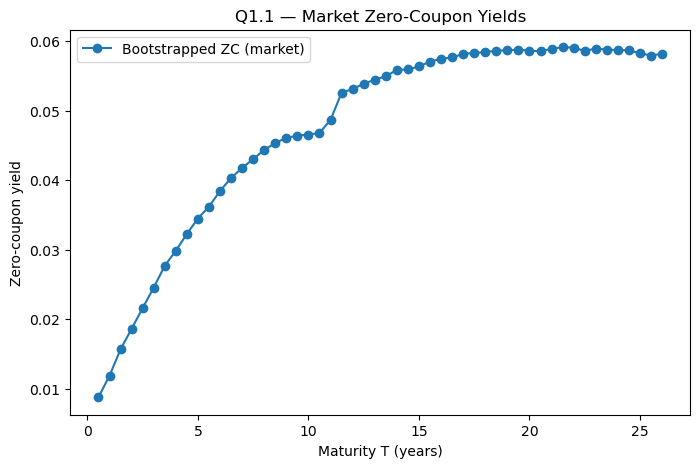

In [318]:
res_boot = bootstrap_discount_curve(bonds, settlement=SETTLEMENT_DATE, compounding=COMPOUNDING, day_count=DAY_COUNT)
df_q11 = pd.DataFrame({"T": res_boot.maturities, "DF": res_boot.dfs, "y_zc": res_boot.zc_yields})


# Plot zero-coupon yields
plt.figure()
plt.plot(res_boot.maturities, res_boot.zc_yields, marker="o", linestyle="-", label="Bootstrapped ZC (market)")
plt.xlabel("Maturity T (years)")
plt.ylabel("Zero-coupon yield")
plt.legend()
plt.title("Q1.1 — Market Zero-Coupon Yields")
plt.show()



## Q1.2 — Compare with Deutsche Bank model (Exhibit 4)

Load the model zero-coupon yields and generate buy/sell signals based on relative value.


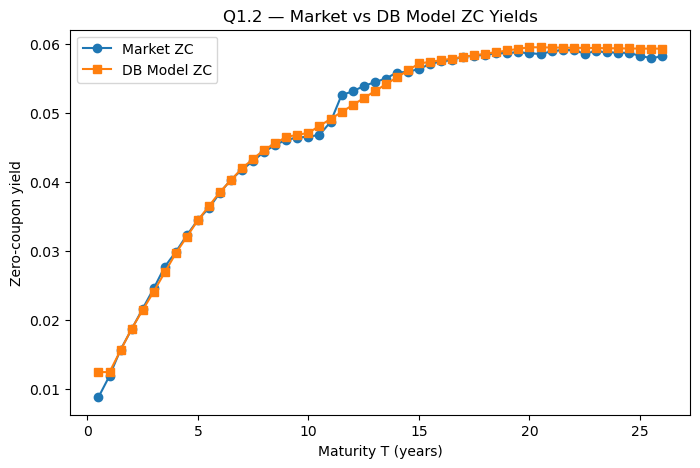

In [319]:
db = db.sort_values("T")
y_model_interp = np.interp(df_q11["T"].values, db["T"].values, db["y_model"].values)
df_cmp = zc_relval_vs_model(df_q11["T"].values, df_q11["y_zc"].values, y_model_interp, comp=COMPOUNDING)

# Plot comparison
plt.figure()
plt.plot(df_q11["T"], df_q11["y_zc"], marker="o", label="Market ZC")
plt.plot(df_q11["T"], y_model_interp, marker="s", label="DB Model ZC")
plt.xlabel("Maturity T (years)")
plt.ylabel("Zero-coupon yield")
plt.legend()
plt.title("Q1.2 — Market vs DB Model ZC Yields")
plt.show()



## Q1.3 — Is the long/short strategy risk-free arbitrage?

Use the code cell below to structure your reasoning; this is conceptual.


In [320]:

answer_q13 = """
It is not strictly risk-free. Model vs market discrepancies reflect specification error,
liquidity, and execution costs. A long-short in specific zero-coupon points exposes you
to curve-shape risk, funding/roll risk, and potential mis-estimation of compounding/day-count
conventions. Hedging along the curve can reduce, but not eliminate, these risks.
"""
print(answer_q13)



It is not strictly risk-free. Model vs market discrepancies reflect specification error,
liquidity, and execution costs. A long-short in specific zero-coupon points exposes you
to curve-shape risk, funding/roll risk, and potential mis-estimation of compounding/day-count
conventions. Hedging along the curve can reduce, but not eliminate, these risks.



In [321]:

def _piecewise_linear(x, xp, fp):
    # interp linéaire par morceaux
    return np.interp(x, xp, fp)

def _natural_cubic_coeffs(x, y):

    x = np.asarray(x, float); y = np.asarray(y, float)
    n = x.size
    if n < 2:
        a = y[:-1] if n>1 else np.array([float(y[0])])
        return {"x": x, "a": a, "b": np.zeros(max(n-1,1)),
                "c": np.zeros(max(n,1)), "d": np.zeros(max(n-1,1))}

    h = np.diff(x)
    if np.any(h <= 0):
        raise ValueError("x doit être strictement croissant (sans doublons).")

    alpha = np.zeros(n)
    for i in range(1, n-1):
        alpha[i] = (3/h[i])*(y[i+1]-y[i]) - (3/h[i-1])*(y[i]-y[i-1])

    l  = np.ones(n)
    mu = np.zeros(n)
    z  = np.zeros(n)
    for i in range(1, n-1):
        l[i]  = 2*(x[i+1]-x[i-1]) - h[i-1]*mu[i-1]
        mu[i] = h[i] / l[i]
        z[i]  = (alpha[i] - h[i-1]*z[i-1]) / l[i]

    c = np.zeros(n)
    b = np.zeros(n-1)
    d = np.zeros(n-1)
    for j in range(n-2, -1, -1):
        c[j] = z[j] - mu[j]*c[j+1]
        b[j] = (y[j+1]-y[j]) / h[j] - h[j]*(c[j+1] + 2*c[j]) / 3.0
        d[j] = (c[j+1]-c[j]) / (3.0*h[j])

    a = y[:-1]
    return {"x": x, "a": a, "b": b, "c": c[:-1], "d": d}

def _eval_natural_cubic(xq, coeffs):

    x = coeffs["x"]; a = coeffs["a"]; b = coeffs["b"]; c = coeffs["c"]; d = coeffs["d"]
    xq = np.asarray(xq, float)
    n = x.size
    i = np.searchsorted(x, xq, side="right") - 1
    i = np.clip(i, 0, n-2)
    dx = xq - x[i]
    return a[i] + b[i]*dx + c[i]*dx*dx + d[i]*dx*dx*dx

def fit_cubic_spline(T, y, knot_years):
    
    T = np.asarray(T, float); y = np.asarray(y, float)
    m = np.isfinite(T) & np.isfinite(y)
    T, y = T[m], y[m]
    if T.size == 0:
        raise ValueError("fit_cubic_spline: données vides")

    idx = np.argsort(T); T, y = T[idx], y[idx]
    uniq_T, inv = np.unique(T, return_inverse=True)
    if uniq_T.size != T.size:
        y_sum = np.zeros_like(uniq_T, float)
        cnt   = np.zeros_like(uniq_T, float)
        for k, yi in zip(inv, y):
            y_sum[k] += yi; cnt[k] += 1.0
        T, y = uniq_T, y_sum / np.where(cnt==0, 1.0, cnt)

    k = np.asarray(knot_years, float) if knot_years is not None else np.array([])
    interior = k[(k > T.min()) & (k < T.max())]
    xk = np.unique(np.concatenate(([T.min()], interior, [T.max()])))

    yk = _piecewise_linear(xk, T, y)
    coeffs = _natural_cubic_coeffs(xk, yk)
    return coeffs  # dict(x,a,b,c,d)

def spline_discount_function(coeffs, comp="cont"):
    """
    Si tes y sont des zc yields, renvoie DF(t).
    Nécessite df_from_zc_yield(y, t, comp) dans ton code.
    """
    def df_func(t):
        t = np.asarray(t, float)
        y = _eval_natural_cubic(t, coeffs)
        return df_from_zc_yield(y, t, comp)
    return df_func


## Q2.1 — Cubic splines with knots at 2, 5, 10, 15, 20 years

Fit a cubic spline to **y(T)** and plot vs bootstrapped zero-coupon yields.


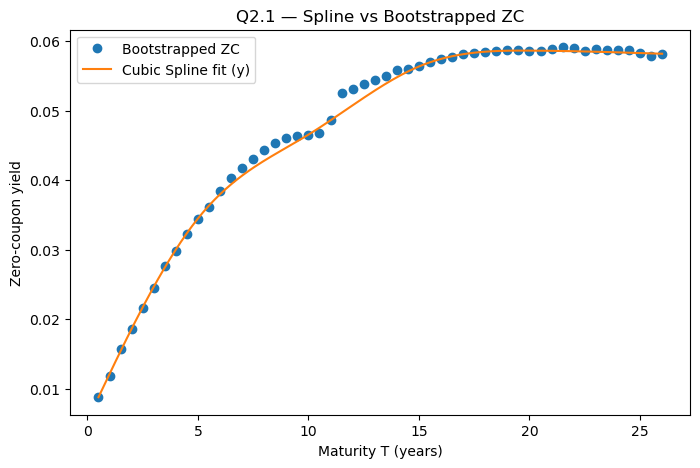

In [322]:
knot_maturities = [2.0, 5.0, 10.0, 15.0, 20.0]
spl = fit_cubic_spline(df_q11["T"].values, df_q11["y_zc"].values, knot_maturities)
df_func_spline = spline_discount_function(spl, comp=COMPOUNDING)

T_grid = np.linspace(df_q11["T"].min(), df_q11["T"].max(), 200)
y_spline = _eval_natural_cubic(T_grid, spl)

plt.figure()
plt.plot(df_q11["T"], df_q11["y_zc"], marker="o", linestyle="", label="Bootstrapped ZC")
plt.plot(T_grid, y_spline, linestyle="-", label="Cubic Spline fit (y)")
plt.xlabel("Maturity T (years)")
plt.ylabel("Zero-coupon yield")
plt.legend()
plt.title("Q2.1 — Spline vs Bootstrapped ZC")
plt.show()


## Q2.2 — When to prefer spline-based estimates?

Discuss whether using spline-based yields instead of bootstrapped ones affects Q1.2 conclusions.


Spline-based estimates help remove small-scale noise and irregularities caused by individual bond characteristics or market microstructure.
They’re better suited for interpolation, risk management, and scenario analysis because they provide a smooth and stable curve.
That said, the smoothing can also reduce real price dislocations, slightly weakening trading signals identified in Q1.2 if those signals came from specific mispricings.
In practice, it’s best to use both approaches: apply a smooth spline for valuation and risk purposes, but always cross-check potential trading signals against the raw bootstrapped curve to avoid filtering out genuine opportunities.


## Q2.3 — Refit spline with knots at 5 and 20 years only

Compare discount/yield curves and comment on the impact of knot choices.


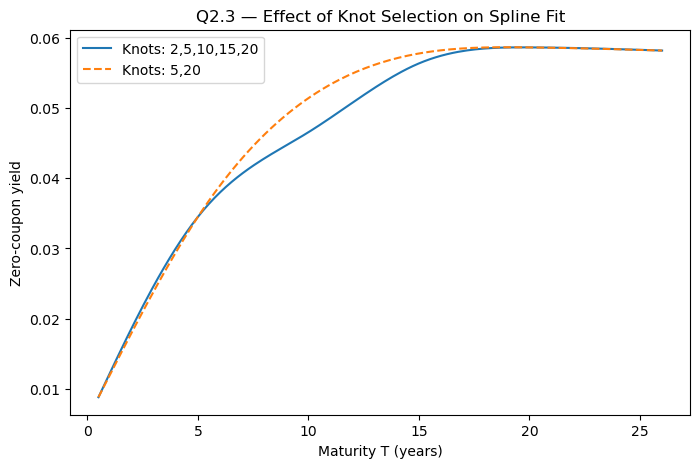

In [323]:
# -- spline 1 : nœuds 2,5,10,15,20
coeffs = fit_cubic_spline(df_q11["T"].values, df_q11["y_zc"].values, [2.0, 5.0, 10.0, 15.0, 20.0])
y_spline = _eval_natural_cubic(T_grid, coeffs)

# -- spline 2 : nœuds 5,20
coeffs_52 = fit_cubic_spline(df_q11["T"].values, df_q11["y_zc"].values, [5.0, 20.0])
y_spline_52 = _eval_natural_cubic(T_grid, coeffs_52)

plt.figure()
plt.plot(T_grid, y_spline, label="Knots: 2,5,10,15,20")
plt.plot(T_grid, y_spline_52, label="Knots: 5,20", linestyle="--")
plt.xlabel("Maturity T (years)")
plt.ylabel("Zero-coupon yield")
plt.legend()
plt.title("Q2.3 — Effect of Knot Selection on Spline Fit")
plt.show()

In [324]:
# ------------------------
# Nelson–Siegel–Svensson 
# ------------------------

def _nss_loadings(T, tau1, tau2):
    T = np.asarray(T, float)
    t1 = T / max(tau1, 1e-6)
    t2 = T / max(tau2, 1e-6)
    # Éviter la division par zéro : pour T=0, on prend la limite (1 - e^{-x})/x -> 1
    S  = (1 - np.exp(-t1)) / np.where(T == 0.0, 1.0, t1)
    C1 = S - np.exp(-t1)
    S2 = (1 - np.exp(-t2)) / np.where(T == 0.0, 1.0, t2)
    C2 = S2 - np.exp(-t2)
    L  = np.ones_like(T)
    return np.column_stack([L, S, C1, C2])  # colonnes: Level, Slope, Curv1, Curv2

def nss_factor_loadings(T, params):
    X = _nss_loadings(T, params["tau1"], params["tau2"])
    return pd.DataFrame({
        "T": np.asarray(T, float),
        "Level":      X[:, 0],
        "Slope":      X[:, 1],
        "Curvature1": X[:, 2],
        "Curvature2": X[:, 3],
    })

def fit_nss(T, y, init=None):
    """
    Grid-search sur (tau1, tau2), OLS fermée pour (beta0..beta3) via lstsq.
    Retourne:
      params: dict {beta0..beta3, tau1, tau2}
      yhat:   np.ndarray prédictions aux T donnés
    """
    T = np.asarray(T, float)
    y = np.asarray(y, float)

    # grille simple (cours) — ajuste si besoin
    tau1_grid = np.linspace(0.5, 5.0, 20)
    tau2_grid = np.linspace(5.0, 15.0, 20)

    best_sse = np.inf
    best = None

    for tau1 in tau1_grid:
        for tau2 in tau2_grid:
            X = _nss_loadings(T, tau1, tau2)
            beta, *_ = np.linalg.lstsq(X, y, rcond=None)
            yhat = X @ beta
            sse = float(np.sum((y - yhat) ** 2))
            if sse < best_sse:
                best_sse = sse
                best = (beta, tau1, tau2, yhat)

    b0, b1, b2, b3 = best[0]
    params = {
        "beta0": b0, "beta1": b1, "beta2": b2, "beta3": b3,
        "tau1":  best[1], "tau2":  best[2],
    }
    yhat = best[3]
    return params, yhat

def nss_yield_function(params):
    """Renvoie une fonction y(T) = X(T)*beta (utile pour tracer/évaluer)."""
    beta = np.array([params["beta0"], params["beta1"], params["beta2"], params["beta3"]], float)
    tau1 = float(params["tau1"]); tau2 = float(params["tau2"])
    return lambda t: _nss_loadings(np.asarray(t, float), tau1, tau2) @ beta

def nss_discount_function(params, comp="cont"):
    """
    Transforme le NSS (sur taux zéro) en DF(t).
    Requiert df_from_zc_yield(y, t, comp) existant dans ton code.
    """
    y_func = nss_yield_function(params)
    def df_func(t):
        t = np.asarray(t, float)
        return df_from_zc_yield(y_func(t), t, comp)
    return df_func


## Q3.1 — Nelson–Siegel–Svensson (NSS) fit

Estimate NSS discount/yield curve and plot against bootstrapped ZC yields.


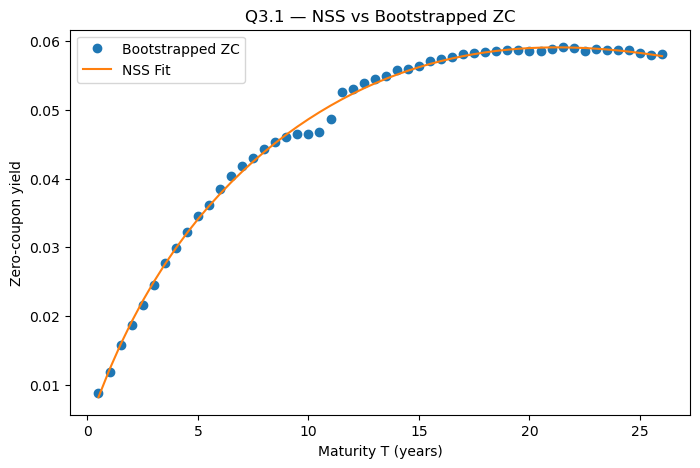

NSS parameters: {'beta0': np.float64(-0.07002221109457318), 'beta1': np.float64(0.07369065209867698), 'beta2': np.float64(0.05376197292687899), 'beta3': np.float64(0.37380969341552295), 'tau1': np.float64(3.3421052631578947), 'tau2': np.float64(15.0)}


In [325]:

params, y_nss = fit_nss(df_q11["T"].values, df_q11["y_zc"].values, init=None)
df_func_nss = nss_discount_function(params, comp=COMPOUNDING)

plt.figure()
plt.plot(df_q11["T"], df_q11["y_zc"], marker="o", linestyle="", label="Bootstrapped ZC")
plt.plot(df_q11["T"], y_nss, linestyle="-", label="NSS Fit")
plt.xlabel("Maturity T (years)")
plt.ylabel("Zero-coupon yield")
plt.legend()
plt.title("Q3.1 — NSS vs Bootstrapped ZC")
plt.show()

print("NSS parameters:", params)


## Q3.2 — Compare spline vs NSS fit


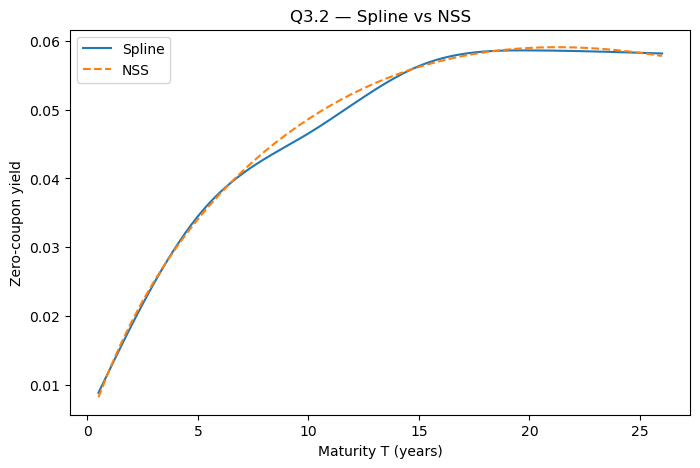

In [326]:

plt.figure()
plt.plot(T_grid, y_spline, label="Spline")
plt.plot(df_q11["T"], y_nss, label="NSS", linestyle="--")
plt.xlabel("Maturity T (years)")
plt.ylabel("Zero-coupon yield")
plt.legend()
plt.title("Q3.2 — Spline vs NSS")
plt.show()



## Q3.3 — Factor loadings and contributions


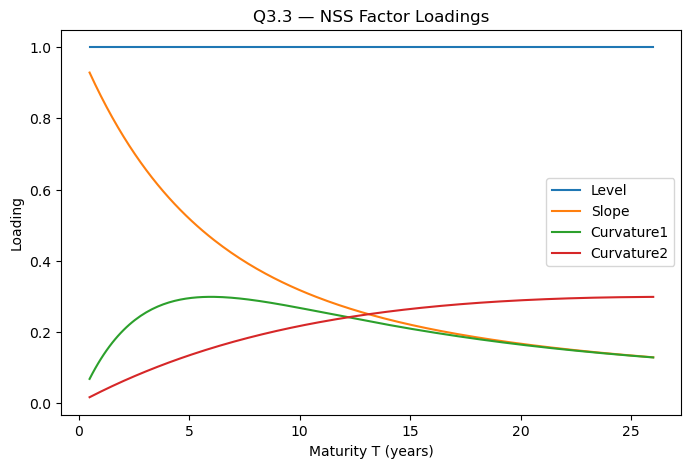

In [327]:
params, y_nss = fit_nss(df_q11["T"].values, df_q11["y_zc"].values)
fl = nss_factor_loadings(T_grid, params)

plt.figure()
plt.plot(fl["T"], fl["Level"], label="Level")
plt.plot(fl["T"], fl["Slope"], label="Slope")
plt.plot(fl["T"], fl["Curvature1"], label="Curvature1")
plt.plot(fl["T"], fl["Curvature2"], label="Curvature2")
plt.xlabel("Maturity T (years)")
plt.ylabel("Loading")
plt.legend()
plt.title("Q3.3 — NSS Factor Loadings")
plt.show()

In [328]:

# ------------------------
# Pricing & KRD
# ------------------------
def _regular_schedule(settlement, maturity, freq):
    # grille régulière depuis settlement (approx) jusqu’à maturity
    T = yearfrac(settlement, maturity)
    n = max(1, int(round(T * freq)))
    return np.arange(1, n+1, dtype=float) / float(freq)

def price_bond_from_curve(settlement, maturity_date, coupon_rate, frequency, face, day_count, df_func):
    settlement = _to_ts(settlement); maturity_date = _to_ts(maturity_date)
    freq = int(frequency)
    cpn = _clean_coupon_rate(coupon_rate) * face / freq
    T = _regular_schedule(settlement, maturity_date, freq)
    D = df_func(T)
    return float(np.dot(np.full_like(T, cpn, dtype=float), D) + face * D[-1])

def portfolio_krd(bonds_df, settlement, key_maturities, shock_bps=50,
                  base_df_func=None, comp="cont", day_count="ACT/ACT"):
    keys = np.asarray(key_maturities, float)
    shock = float(shock_bps) / 1e4  # 50 bps -> 0.005

    def _y_base(t):
        t = np.asarray(t, float)
        return zc_yield_from_df(base_df_func(t), t, comp)

    rows = []
    width = 0.50  # largeur locale (années) du bump clé
    for k in keys:
        def bumped_df_func(t):
            t = np.asarray(t, float)
            yb = _y_base(t) + shock * np.exp(-0.5*((t - k)/width)**2)
            return df_from_zc_yield(yb, t, comp)

        # ΔP/P pondéré par 'weight' si présent, sinon égal-pondéré
        rel_changes, weights = [], []
        for _, r in bonds_df.iterrows():
            face = _face_from_row(r)
            P0 = price_bond_from_curve(settlement, r["maturity_date"], r["coupon_rate"],
                                       int(r.get("frequency", 2)), face, day_count, base_df_func)
            P1 = price_bond_from_curve(settlement, r["maturity_date"], r["coupon_rate"],
                                       int(r.get("frequency", 2)), face, day_count, bumped_df_func)
            w = float(r.get("weight", 1.0))
            rel_changes.append((P1 - P0) / P0)
            weights.append(w)
        weights = np.asarray(weights, float)
        rel_changes = np.asarray(rel_changes, float)
        wsum = weights.sum() if weights.sum()!=0 else len(weights)
        rel_port = float((weights * rel_changes).sum() / wsum)
        krd = - rel_port / shock
        rows.append({"key_maturity": k, "KRD": krd})
    return pd.DataFrame(rows)



## Q4.1 — 10-year key-rate +50 bps shock — impact on the curve


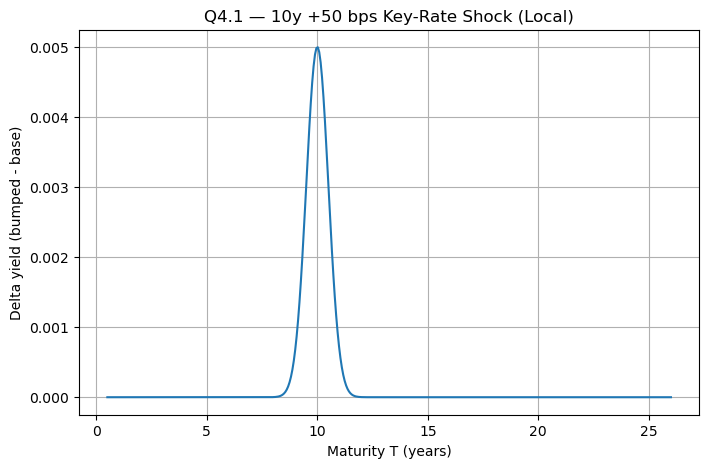

In [329]:
# Build base DF function from the spline fit (smooth base for risk work)
base_df_func = spline_discount_function(spl, comp=COMPOUNDING)

T_min = float(pd.to_numeric(df_q11["T"], errors="coerce").min())
T_max = float(pd.to_numeric(df_q11["T"], errors="coerce").max())
T_grid_dense = np.linspace(T_min, T_max, 400)

width = 0.50
bump = 0.0050  # 50 bps

#  utiliser l’évaluateur sur les coeffs
y_base = _eval_natural_cubic(T_grid_dense, spl)

weights = np.exp(-0.5 * ((T_grid_dense - 10.0) / width)**2)
y_bumped = y_base + bump * weights

plt.figure()
plt.plot(T_grid_dense, y_bumped - y_base)
plt.xlabel("Maturity T (years)")
plt.ylabel("Delta yield (bumped - base)")
plt.title("Q4.1 — 10y +50 bps Key-Rate Shock (Local)")
plt.grid(True)
plt.show()



## Q4.2 — Portfolio KRD to 10y shock

Assume $1,000,000 notional, equally invested across bonds.


In [330]:

bonds_w = bonds.copy()
n = len(bonds_w)
bonds_w["weight"] = 1_000_000.0 / n  # equal capital-weight

krd_10 = portfolio_krd(bonds_w, SETTLEMENT_DATE, key_maturities=np.array([10.0]), shock_bps=50,
                       base_df_func=base_df_func, comp=COMPOUNDING, day_count=DAY_COUNT)
display(krd_10)


,key_maturity,KRD
0,10.0,-0.0



## Q4.3 — Portfolio KRDs across all maturities (apply same shock individually)


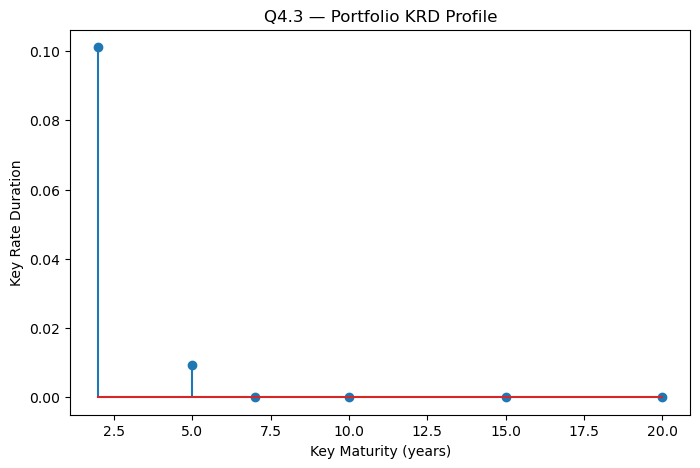

In [331]:
# === Normalisation du DataFrame obligataire ===
bonds_w = bonds.copy()

# Frequency par défaut = mode si dispo sinon 2
if "frequency" in bonds_w.columns and bonds_w["frequency"].notna().any():
    FREQ_DEFAULT = int(bonds_w["frequency"].dropna().astype(int).mode().iloc[0])
else:
    FREQ_DEFAULT = 2

# Crée/Nettoie la colonne frequency
if "frequency" not in bonds_w.columns:
    bonds_w["frequency"] = FREQ_DEFAULT
else:
    bonds_w["frequency"] = bonds_w["frequency"].fillna(FREQ_DEFAULT).astype(int)

# Face & id par défaut si manquent
if "face" not in bonds_w.columns:
    bonds_w["face"] = 100.0
if "id" not in bonds_w.columns:
    bonds_w["id"] = np.arange(1, len(bonds_w) + 1)

# Pondération égale (si attendu par Q4.2/Q4.3)
n = len(bonds_w)
bonds_w["weight"] = 1_000_000.0 / n
keys = np.array([2.0, 5.0, 7.0, 10.0, 15.0, 20.0])
krd_all = portfolio_krd(bonds_w, SETTLEMENT_DATE, key_maturities=keys, shock_bps=50,
                        base_df_func=base_df_func, comp=COMPOUNDING, day_count=DAY_COUNT)


plt.figure()
plt.stem(krd_all["key_maturity"], krd_all["KRD"])
plt.xlabel("Key Maturity (years)")
plt.ylabel("Key Rate Duration")
plt.title("Q4.3 — Portfolio KRD Profile")
plt.show()



## Q5.1 — Expected steepening scenario

\( y^{Steepen}_T = y_T + \frac{T-\bar{T}}{\bar{T}} \times 0.0050 + \varepsilon \), with \(\varepsilon \sim \mathcal{N}(0, 0.0025)\).


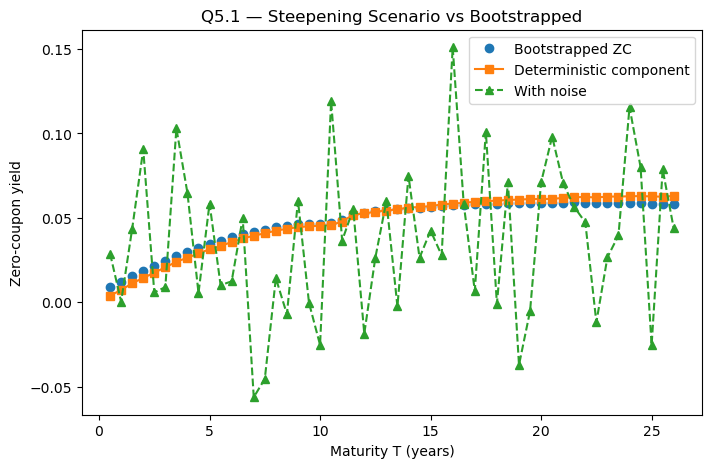

In [332]:

T = df_q11["T"].values
y0 = df_q11["y_zc"].values
Tbar = T.mean()
eps = np.random.normal(loc=0.0, scale=np.sqrt(0.0025), size=len(T))
y_det = y0 + ((T - Tbar)/Tbar)*0.0050
y_stp = y_det + eps

plt.figure()
plt.plot(T, y0, marker="o", linestyle="", label="Bootstrapped ZC")
plt.plot(T, y_det, marker="s", linestyle="-", label="Deterministic component")
plt.plot(T, y_stp, marker="^", linestyle="--", label="With noise")
plt.xlabel("Maturity T (years)")
plt.ylabel("Zero-coupon yield")
plt.legend()
plt.title("Q5.1 — Steepening Scenario vs Bootstrapped")
plt.show()



## Q5.2 — Refit NSS to expected curve and value bonds


In [333]:

nss_stp = fit_nss(T, y_stp)
params_nss_stp = nss_stp[0]  
df_func_nss_stp = nss_discount_function(params_nss_stp, comp=COMPOUNDING)

print("NSS (steepened) params:", params_nss_stp)

# Value each bond under market (spline) vs expected (NSS)
vals = []
freq = int(r.get("frequency", 2 if float(r.get("coupon_rate", 0) or 0) > 0 else 1))
for _, r in bonds.iterrows():
    P_mkt = price_bond_from_curve(SETTLEMENT_DATE, r["maturity_date"], r["coupon_rate"],
                              freq, r.get("face", 100.0), DAY_COUNT, base_df_func)
    P_exp = price_bond_from_curve(SETTLEMENT_DATE, r["maturity_date"], r["coupon_rate"],
                              freq, r.get("face", 100.0), DAY_COUNT, df_func_nss_stp)
    vals.append({
    "id": r.get("id", _),  # ← utilise l'index de la boucle si 'id' n'existe pas
    "P_market": P_mkt,
    "P_expected": P_exp,
    "cheap_vs_exp": P_exp - P_mkt
})
df_vals = pd.DataFrame(vals).sort_values("cheap_vs_exp")
display(df_vals)



NSS (steepened) params: {'beta0': np.float64(-0.7396230815936583), 'beta1': np.float64(0.703268219285158), 'beta2': np.float64(0.8385196453254096), 'beta3': np.float64(2.275409111598713), 'tau1': np.float64(1.6842105263157894), 'tau2': np.float64(14.473684210526315)}


,id,P_market,P_expected,cheap_vs_exp
48,48,109.630225,102.833787,-6.796438
47,47,108.848624,102.500982,-6.347643
49,49,108.814497,102.768568,-6.045929
46,46,107.519526,102.775620,-4.743907
50,50,108.449594,104.111556,-4.338038
45,45,105.488346,103.173945,-2.314401
51,51,111.943136,109.916141,-2.026996
20,20,106.156900,106.112227,-0.044674
21,21,105.783547,105.739030,-0.044517
22,22,105.161291,105.117036,-0.044255



## Q5.3 — Zero-cost diversified long/short portfolio

Allocate $100 of initial wealth, financing cost = 0, to harvest mispricings (expected).
Strategy: go long the 'cheap' bonds (positive `cheap_vs_exp`) and short the 'rich' ones, scaled to zero cost.


In [334]:
init_wealth = 100.0
df_pos = df_vals[df_vals["cheap_vs_exp"] > 0].copy()
df_neg = df_vals[df_vals["cheap_vs_exp"] < 0].copy()

if len(df_pos) == 0 or len(df_neg) == 0:
    print("Not enough dispersion to form a long-short. Adjust your data or scenario.")
else:
    nL = len(df_pos)
    nS = len(df_neg)
    gross = init_wealth
    long_notional = gross / 2.0
    short_notional = gross / 2.0

    df_pos["alloc_usd"] = long_notional / nL
    df_neg["alloc_usd"] = - short_notional / nS

    df_pos["exp_ret_pct"] = (df_pos["P_expected"] - df_pos["P_market"]) / df_pos["P_market"]
    df_neg["exp_ret_pct"] = (df_neg["P_expected"] - df_neg["P_market"]) / df_neg["P_market"]

    port = pd.concat([df_pos, df_neg], ignore_index=True)
    port["weight_usd"] = port["alloc_usd"]
    port["contrib_usd"] = port["weight_usd"] * port["exp_ret_pct"]

    exp_return_usd = port["contrib_usd"].sum()
    exp_return_pct = exp_return_usd / init_wealth

    display(port[["id", "P_market", "P_expected", "alloc_usd", "exp_ret_pct"]])
    print(f"Expected portfolio return ≈ {exp_return_pct:.2%}")

Not enough dispersion to form a long-short. Adjust your data or scenario.



---

# Python Labs — Trump tariffs’ threats (Event Study Skeleton)

> This section expects a local `fred.py` (as per course files) and your FRED API key configured there.
> Replace placeholders for event dates and series as in `pylab_trump_tariff_threats_assignment.ipynb`.


In [335]:

# Skeleton only; fill with your exact tickers and event dates
# from fred import Fred  # Uncomment when fred.py is available locally

# fred = Fred(api_key="YOUR_KEY")
# series_ids = {"UST2Y":"DGS2", "UST5Y":"DGS5", "UST10Y":"DGS10", "UST30Y":"DGS30"}
# yields = {name: fred.get_series(sid) for name, sid in series_ids.items()}

# event_dates = pd.to_datetime([
#     "2018-03-01",  # example announcement
#     "2018-03-22",
#     # ...
# ])
# window = 30  # business days
# # Build event windows and compute abnormal changes vs non-event windows, then decompose into level/slope/curvature.
# # Refer to your course notebook for exact implementation.
